In [22]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, UpSampling1D
from keras.optimizers import Adam, RMSprop, SGD
from sklearn.cross_validation import KFold
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import scipy.io

In [23]:
# Setting the random seeds
random.seed(1)
np.random.seed(1337)

In [24]:
def load_data(filepath):

# Description: This function is responsible for loading our data.
# Args in: filepath - the path of the .mat file containing the data
# Returns: inputs - the data, labels - the labels corresponding to the data, 
#            patients - the patients corresponding to the data

    mat = scipy.io.loadmat(filepath)
    inputs = mat['Xrec'][:]
    labels = mat['Y']
    patients = mat['patientID']

    labels = np.einsum('ij->ji', labels)
    labels = [label for sublist in labels for label in sublist]
    patients = np.einsum('ij->ji', patients)
    patients = [patient for sublist in patients for patient in sublist]

    return inputs, labels, patients

In [25]:
def filter_duplicates(duplicates_list, patients):

# Description: This function is responsible for filtering out
# some patients that are found to be present in more than one classes.
# Args in & Returns are self-explanatory.
    
    patients = list(patients)
    
    for duplicate in duplicates_list:
        patients = list(filter(lambda a: a != duplicate, patients))
    
    return np.asarray(patients)

In [26]:
inputs, labels, patients = load_data('/home/nikos/Desktop/Zacharaki/PARAFAC missing values 0_90/ReconstructedTensorAndFeatures90Missing_StrSGD.mat')

In [27]:
patients = filter_duplicates([1002, 1104], patients)

In [28]:
def split_train_test(inputs, targets, patients, patients_for_val):

# Description: This function is responsible for splitting our data into training and test data
# Args in: patients_for_val - list containing the patients for our test data
# Returns: the data and labels of our training and test data

    X_train_size = X_val_size = 0

    patients_for_train = [item for item in list(np.unique(patients)) if item not in patients_for_val]
    idpatients_val = []
    for patient in patients_for_val:
        idpatient = [i for i, x in enumerate(patients) if x == patient]
        idpatients_val.append(idpatient)
    idpatients_val = [item for sublist in idpatients_val for item in sublist]
    X_val = [inputs[i] for i in idpatients_val]
    y_val = [targets[i] for i in idpatients_val]

    idpatients_train = list(set([i for i in range(inputs.shape[0])]) - set(idpatients_val))
    inputs = [inputs[i] for i in idpatients_train]
    targets = [targets[i] for i in idpatients_train]

    return np.asarray(inputs), np.asarray(targets), np.asarray(X_val), np.asarray(y_val)

In [29]:
X_train, y_train, X_test, y_test = split_train_test(inputs, labels, patients, [1106, 1107, 2097])

In [30]:
def preprocess_data(X_train, X_test):

# Description: This function preprocesses our data. 
# We want to ensure that our training data have zero mean and unit variance. 
# We also use subtract the same mean from the test data and then devide them by
# the same standard deviation. We do that to ensure that no information about the
# test set distribution is known ahead of time.

# Args in & Returns are self-explanatory.

    X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis = 0)
    
    X_train, X_val, train_ground, valid_ground = train_test_split(X_train, X_train, test_size = 0.1, random_state = 13)

    X_test = (X_test -  np.mean(X_train, axis=0)) / np.std(X_train, axis = 0)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1] * X_val.shape[2]))
    train_ground = np.reshape(train_ground, (train_ground.shape[0], train_ground.shape[1] * train_ground.shape[2]))
    valid_ground = np.reshape(valid_ground, (valid_ground.shape[0], valid_ground.shape[1] * valid_ground.shape[2]))
    
    return X_train, X_val, train_ground, valid_ground, X_test

In [31]:
X_train, X_val, train_ground, valid_ground, X_test = preprocess_data(X_train, X_test)

In [32]:
adam = Adam(lr = 0.001)

In [33]:
input_signal = Input(shape = (X_train.shape[1],))
encoded = Dense(32, activation = 'relu')(input_signal)

# decoder
decoded = Dense(1500*7, activation = 'sigmoid')(encoded)

autoencoder = Model(input = input_signal, output = decoded)

encoder = Model(input = input_signal, output = encoded)
encoded_input = Input(shape=(32,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(loss="mean_squared_error", optimizer=adam, metrics=['mse'])
print(autoencoder.summary())
history = autoencoder.fit(X_train, train_ground, epochs=30, batch_size=128, 
                                    validation_data=(X_val, valid_ground), verbose=2, shuffle=True)

/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/nikos/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10500)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                336032    
_________________________________________________________________
dense_10 (Dense)             (None, 10500)             346500    
Total params: 682,532
Trainable params: 682,532
Non-trainable params: 0
_________________________________________________________________
None
Train on 16512 samples, validate on 1835 samples
Epoch 1/30
 - 2s - loss: 0.7392 - mean_squared_error: 0.7392 - val_loss: 0.6225 - val_mean_squared_error: 0.6225
Epoch 2/30
 - 2s - loss: 0.6591 - mean_squared_error: 0.6591 - val_loss: 0.6166 - val_mean_squared_error: 0.6166
Epoch 3/30
 - 2s - loss: 0.6559 - mean_squared_error: 0.6559 - val_loss: 0.6168 - val_mean_squared_error: 0.6168
Epoch 4

In [34]:
encoder_X_train = [encoder.predict(X_train), encoder.predict(X_val)]
encoder_X_train = [i for sublist in encoder_X_train for i in sublist]
encoder_X_test = encoder.predict(X_test)

encoder_X_train = np.asarray(encoder_X_train)
encoder_X_test = np.asarray(encoder_X_test)

In [57]:
c = list(zip(encoder_X_train, y_train))
random.shuffle(c)
encoder_X_train, y_train = zip(*c)

c = list(zip(encoder_X_test, y_test))
random.shuffle(c)
encoder_X_test, y_test = zip(*c)

encoder_X_train = np.asarray(encoder_X_train)
encoder_X_test = np.asarray(encoder_X_test)

In [58]:
def one_hot(labels, n_class = 6):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = []
    for i in labels:
        y.append(expansion[int(i)])
    y = np.asarray(y)

    return y

In [59]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import keras.backend as K

class BalancedAccuracy(Callback):
    def __init__(self, train_data, validation_data):
        super(BalancedAccuracy, self).__init__()
        self.acas = []
        self.validation_data = validation_data
        self.train_data = train_data
        
    def on_epoch_end(self, epoch, logs={}):

        X_val = self.validation_data[0]
        y_val = self.validation_data[1]

        X_train = self.train_data[0]
        y_train = self.train_data[1]

        y_val_pred = self.model.predict(X_val)
        y_train_pred = self.model.predict(X_train)

        val_score = self.eval_avg_class_acc(y_val, y_val_pred)
        train_score = self.eval_avg_class_acc(y_train, y_train_pred)

        self.acas.append([val_score])
        self.acas.append([train_score])

        print("\nBalanced Accuracy - train: %.3f \t val: %.3f"%(train_score, val_score))        
        
    def eval_avg_class_acc(self, y_true, y_pred):

        # decode one-hot to single labels
        y_pred = y_pred.round()
        y_pred = [ np.argmax(pred, axis = 0) for pred in y_pred ]
        y_true = [ np.argmax(label, axis = 0) for label in y_true ]

        cf = confusion_matrix(y_true, y_pred)
        if np.unique(y_true).shape[0] == 2:
            sensitivity = float(cf[1][1]) / float((cf[1][1] + cf[1][0]))
            specificity = float(cf[0][0]) / float((cf[0][1] + cf[0][0]))

            balanced_acc = (sensitivity + specificity) / 2
        else:
            balanced_acc = accuracy_score(y_true, y_pred)

        return balanced_acc

def weighted_categorical_crossentropy(y_true, y_pred, weights):
    
    weights = K.variable(weights)
        
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    return loss

In [60]:
from functools import partial

# Weighted loss function to tackle class imbalance in the dataset

weights = np.array([float(len(y_train)) / float(list(y_train).count(0)), float(len(y_train)) / float(list(y_train).count(1)), float(len(y_train)) / float(list(y_train).count(2))])
w_cat_crossentropy = partial(weighted_categorical_crossentropy, weights = weights)
w_cat_crossentropy.__name__ = 'weighted_categorical_crossentropy'
        
balanced_accuracy = BalancedAccuracy(train_data = (encoder_X_train, y_train), validation_data = (encoder_X_test, y_test))
CALLBACKS = [balanced_accuracy]

In [70]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Activation, BatchNormalization
from keras.layers import Dropout
import tensorflow as tf 

model = Sequential()
model.add(Dense(128, kernel_initializer="uniform", input_shape = (32,)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation(tf.nn.softmax))

adam = Adam(lr = 0.00001)
y_train_one_hot = one_hot(y_train, 3)
y_test_one_hot = one_hot(y_test, 3)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.fit(encoder_X_train, y_train_one_hot, epochs=500, batch_size=128, validation_data=(encoder_X_test, y_test_one_hot), 
          verbose=2, shuffle=True, callbacks=CALLBACKS)

Train on 18347 samples, validate on 1393 samples
Epoch 1/500
 - 1s - loss: 1.9111 - acc: 0.3170 - val_loss: 1.2565 - val_acc: 0.2505

Balanced Accuracy - train: 0.465 	 val: 0.250
Epoch 2/500
 - 1s - loss: 1.8441 - acc: 0.3209 - val_loss: 1.2275 - val_acc: 0.2477

Balanced Accuracy - train: 0.510 	 val: 0.265
Epoch 3/500
 - 1s - loss: 1.7783 - acc: 0.3227 - val_loss: 1.2022 - val_acc: 0.2419

Balanced Accuracy - train: 0.556 	 val: 0.324
Epoch 4/500
 - 1s - loss: 1.7063 - acc: 0.3312 - val_loss: 1.1743 - val_acc: 0.2391

Balanced Accuracy - train: 0.598 	 val: 0.467
Epoch 5/500
 - 1s - loss: 1.6895 - acc: 0.3306 - val_loss: 1.1537 - val_acc: 0.2362

Balanced Accuracy - train: 0.637 	 val: 0.464
Epoch 6/500
 - 0s - loss: 1.6398 - acc: 0.3366 - val_loss: 1.1357 - val_acc: 0.2333

Balanced Accuracy - train: 0.678 	 val: 0.463
Epoch 7/500
 - 0s - loss: 1.6102 - acc: 0.3398 - val_loss: 1.1228 - val_acc: 0.2376

Balanced Accuracy - train: 0.708 	 val: 0.463
Epoch 8/500
 - 1s - loss: 1.6109 -

In [71]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[  0 645   0]
 [  0 349   0]
 [  0 399   0]]
Normalized confusion matrix
[[ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


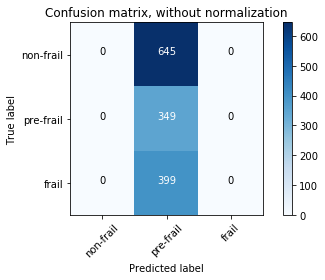

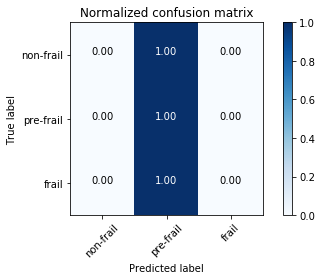

In [72]:
preds = model.predict(encoder_X_test)

# decode one-hot to single labels
preds = [ np.argmax(pred, axis = 0) for pred in preds ]
labels = [ np.argmax(label, axis = 0) for label in y_test_one_hot ]

# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["non-frail", "pre-frail", "frail"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["non-frail", "pre-frail", "frail"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()